In [1]:
# SEP769 - July 27, 2021
# Amir Kamaleddine, Ernani Fantinatti, Mohammed Ibraheem
# CNN model for classifying normal and imbalanced motors as part of the MAFAULDA motor fault dataset
# If training, we suggest you use GPU acceleration in Colab
# https://github.com/efantinatti/MAFAULDA_SEP769


In [2]:
# Load in tensorboard extension to view results interactively
%load_ext tensorboard


In [3]:
# Load relevant libraries
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D
import matplotlib.pyplot as plt
import glob
import datetime

In [4]:
# For Google Colab only
# Pulling processed data from public folder
# Credit to this stack overflow forum: https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import gdown

url = 'https://drive.google.com/uc?id=1otE_HKfM24r9Hp1-e5xodSkgve1o3DO5' 
output = 'jul27data.zip'
gdown.download(url, output, quiet=False)

!unzip /content/jul27data.zip
!rm -rf sample_data


Downloading...
From: https://drive.google.com/uc?id=1otE_HKfM24r9Hp1-e5xodSkgve1o3DO5
To: /content/jul27data.zip
154MB [00:01, 119MB/s]


Archive:  /content/jul27data.zip
   creating: jul27data/
  inflating: jul27data/test_data.txt  
  inflating: jul27data/test_label.txt  
  inflating: jul27data/train_data.txt  
  inflating: jul27data/train_label.txt  


In [5]:
# Cloning github repo
!git clone https://github.com/efantinatti/MAFAULDA_SEP769.git


Cloning into 'MAFAULDA_SEP769'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 285 (delta 91), reused 131 (delta 31), pack-reused 0
Receiving objects: 100% (285/285), 11.37 MiB | 21.72 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [6]:
# Decide whether to load model from a .h5 file or train a new one
# 0 if training the model again
# 1 if loading model
saved_model = 0


In [7]:
#Delete tensorboard logs from previous runs
#If using Collab or Unix system use !rm, otherwise
#if using windows use skip this line
!rm -rf ./logs/


In [8]:
# Loads train/test data from .txt files to np arrays 
# Ensure you choose the correct file directory

dir = '/content/jul27data/'

train_reload = np.loadtxt(dir + 'train_data.txt')
test_reload = np.loadtxt(dir + 'test_data.txt')

print("Loaded data files...")


Loaded data files...


In [9]:
# Shaping the training/testing data
# Shapes the data into an nx500x8 array
# Each sequence is 500 timesteps (10 ms of data collection)

train_data = np.reshape(train_reload,(-1,500, 8))
test_data = np.reshape(test_reload,(-1,500, 8))


In [10]:
# Loads labels corresponding to training/test data
train_label = np.loadtxt(dir + 'train_label.txt').astype(int)
test_label = np.loadtxt(dir + 'test_label.txt').astype(int)


In [11]:
# Build the model
# Sequential model
model = Sequential()

# Conv1D is used to perform convolution on temporal data
model.add(Conv1D(30, (5), input_shape=(500, 8), padding = 'same', strides = 1, activation='relu'))

# Flatten before feeding into dense layers
model.add(Flatten())

# Dense layers and Output Layer
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
# Binary crossentropy for a binary classifier
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 500, 30)           1230      
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                480032    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 481,807
Trainable params: 481,807
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Log model training process with Tensorboard
ld = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callTensorboard = tf.keras.callbacks.TensorBoard(log_dir=ld, histogram_freq=1)


In [13]:
if saved_model == 0:
    # Train model
    # Note that validation data is NOT used to train model at all
    history = model.fit(train_data, train_label, validation_data=(test_data, test_label), callbacks = [callTensorboard], epochs=10, batch_size=32)
    model.save('/content/MAFAULDA_SEP769/Models/CNN.h5')
else:
    # Load model from .h5 file
    model = load_model('/content/MAFAULDA_SEP769/Models/CNN.h5')


Epoch 1/10
156/156 [==============================] - 45s 13ms/step - loss: 0.4008 - accuracy: 0.8132 - val_loss: 0.1853 - val_accuracy: 0.9531
Epoch 2/10
156/156 [==============================] - 1s 6ms/step - loss: 0.1111 - accuracy: 0.9635 - val_loss: 0.1439 - val_accuracy: 0.9650
Epoch 3/10
156/156 [==============================] - 1s 7ms/step - loss: 0.0675 - accuracy: 0.9786 - val_loss: 0.1298 - val_accuracy: 0.9751
Epoch 4/10
156/156 [==============================] - 1s 6ms/step - loss: 0.0510 - accuracy: 0.9872 - val_loss: 0.1075 - val_accuracy: 0.9638
Epoch 5/10
156/156 [==============================] - 1s 6ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0810 - val_accuracy: 0.9763
Epoch 6/10
156/156 [==============================] - 1s 7ms/step - loss: 0.0260 - accuracy: 0.9926 - val_loss: 0.0741 - val_accuracy: 0.9802
Epoch 7/10
156/156 [==============================] - 1s 6ms/step - loss: 0.0193 - accuracy: 0.9953 - val_loss: 0.0740 - val_accuracy: 0.9847
Epoc

In [14]:
# Evaluate model performance with test set
test_accuracy = model.evaluate(test_data, test_label)


56/56 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.9814


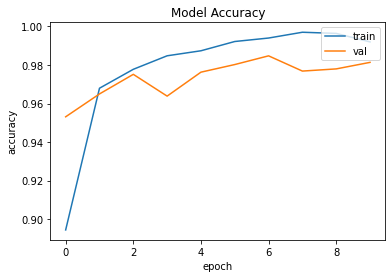

In [15]:
# Plot model accuracy over epoch if trained
#If you have chosen 'saved_model == 1', chart won't be presented.
if saved_model == 0:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
#If you have chosen 'saved_model == 1', Tensorboard won't work.
%tensorboard --logdir logs/fit
